In [633]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Подключение библиотек, предупреждений, стилей

In [671]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Расчет R2, отображение значений

In [635]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("valid R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Valid sample prediction')

    plt.show()

#### Загрузка данных

#### Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры



In [636]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [637]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


#### Загрузка тестовых данных

In [638]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


#### Анализ данных

In [639]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [640]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [641]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

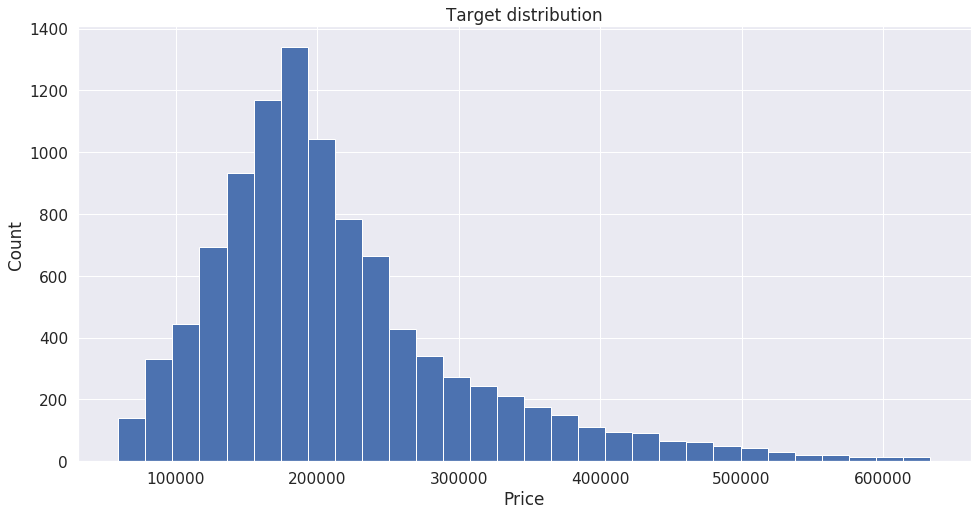

In [642]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [643]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [644]:
# поиск пропусков

for col in train_df.columns:
    pct_missing = np.mean(train_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Id - 0.0%
DistrictId - 0.0%
Rooms - 0.0%
Square - 0.0%
LifeSquare - 21.0%
KitchenSquare - 0.0%
Floor - 0.0%
HouseFloor - 0.0%
HouseYear - 0.0%
Ecology_1 - 0.0%
Ecology_2 - 0.0%
Ecology_3 - 0.0%
Social_1 - 0.0%
Social_2 - 0.0%
Social_3 - 0.0%
Healthcare_1 - 48.0%
Helthcare_2 - 0.0%
Shops_1 - 0.0%
Shops_2 - 0.0%
Price - 0.0%


#### Разделяем количественные и категориальные данные

In [645]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


In [646]:
df_obj_features = train_df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c0d4b9110>,
      dtype=object)

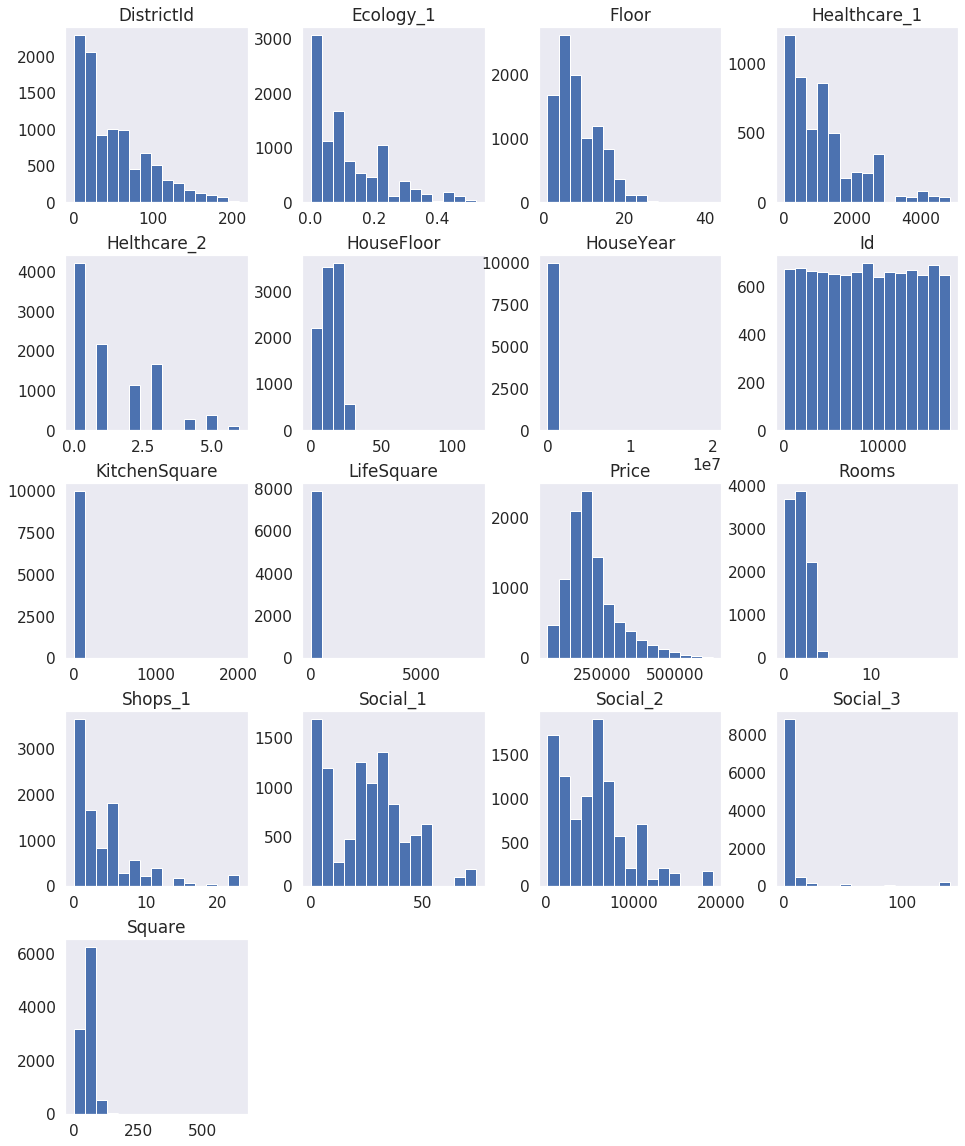

In [647]:
df_num_features.hist(figsize=(16,20), bins=15, grid=False)

#### Зависимости признаков (пример)

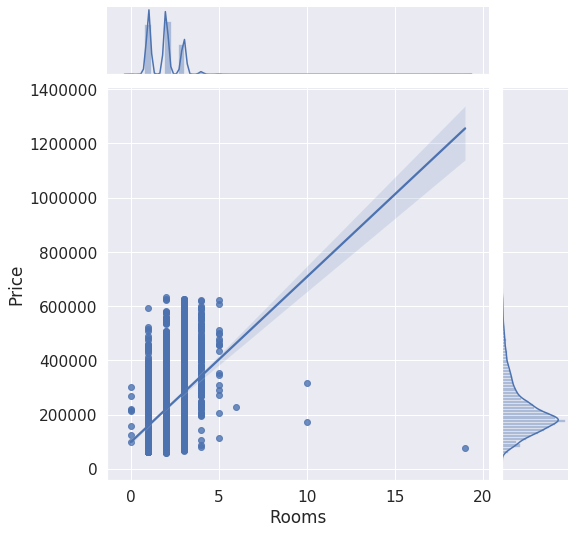

In [648]:
grid = sns.jointplot(train_df['Rooms'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

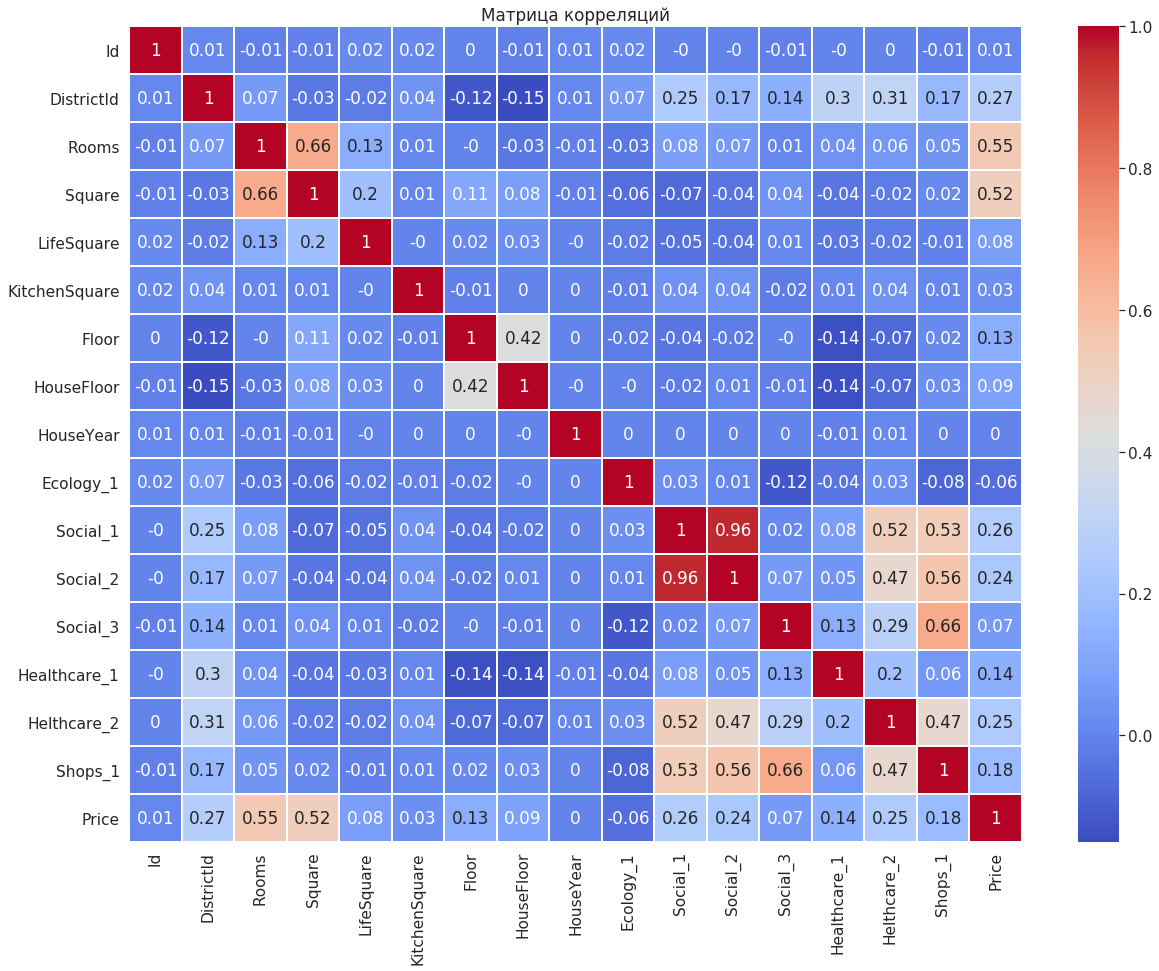

In [649]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=1, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

#### Обработка данных

In [650]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        #X['Rooms_outlier'] = 0
        #X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[(X['Rooms'] == 0) | X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor'] 
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year 
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
    
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [651]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_by_Social = None
        self.med_by_Health = None
        self.med_price_by_ESD = None
        self.med_price_by_HD = None
        self.med_price_by_EcSocD = None
        
    def fit(self, X, y=None):
        
        X = X.copy()

        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
              

            self.med_by_Social = df.groupby(['Social_1', 'Ecology_1'], as_index=False).agg({'Healthcare_1':'median'})\
                                            .rename(columns={'Healthcare_1':'MedBySocial'})
            
            self.med_by_Social_median = self.med_by_Social['MedBySocial'].median()
            
            
            self.med_by_Health = df.groupby(['Healthcare_1', 'Helthcare_2'], as_index=False).agg({'Price':'mean'})\
                                            .rename(columns={'Price':'MedByHealth'})
            
            self.med_by_Health_median = self.med_by_Health['MedByHealth'].mean()
            
            
            self.med_by_ESD = df.groupby(['Ecology_1', 'Shops_1'], as_index=False).agg({'DistrictId':'median'})\
                                            .rename(columns={'DistrictId':'MedByESD'})
            
            self.med_by_ESD_median = self.med_by_ESD['MedByESD'].median()
            
            
            self.med_by_EHM = df.groupby(['Ecology_1', 'Healthcare_1'], as_index=False).agg({'DistrictId':'median'})\
                                            .rename(columns={'DistrictId':'MedByEHM'})
            self.med_by_EHM_median = self.med_by_EHM['MedByEHM'].median()
            
            
            self.med_by_EcSocD = df.groupby(['Ecology_1', 'Social_1'], as_index=False).agg({'DistrictId':'median'})\
                                            .rename(columns={'DistrictId':'MedByEcSocD'})
            self.med_by_EcSocD_median = self.med_by_EcSocD['MedByEcSocD'].median()          
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            self.med_price_by_floor_year = df.groupby(['HouseYear', 'Floor'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median() 

        
    def transform(self, X):
        

        #трансформация категориальных данных
        ord_enc = OrdinalEncoder()
        X['Ecology_2_code'] = ord_enc.fit_transform(X[['Ecology_2']])
        X['Ecology_3_code'] = ord_enc.fit_transform(X[['Ecology_3']])
        X['Shops_2_code'] = ord_enc.fit_transform(X[['Shops_2']])
        X = X.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # Target encoding
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['HouseYear', 'Floor'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
             
        if self.med_by_Social is not None:
            X = X.merge(self.med_by_Social, on=['Social_1', 'Ecology_1'], how='left')
            X['MedBySocial'].fillna(self.med_by_Social_median, inplace=True)
        
        if self.med_by_Health is not None:
            X = X.merge(self.med_by_Health, on=['Healthcare_1', 'Helthcare_2'], how='left')
            X['MedByHealth'].fillna(self.med_by_Health_median, inplace=True)
            
        if self.med_by_ESD is not None:
            X = X.merge(self.med_by_ESD, on=['Ecology_1', 'Shops_1'], how='left')
            X['MedByESD'].fillna(self.med_by_ESD_median, inplace=True)
            
        if self.med_by_EHM is not None:
            X = X.merge(self.med_by_EHM, on=['Ecology_1', 'Healthcare_1'], how='left')
            X['MedByEHM'].fillna(self.med_by_EHM_median, inplace=True)
            
        if self.med_by_EcSocD is not None:
            X = X.merge(self.med_by_EcSocD, on=['Ecology_1', 'Social_1'], how='left')
            X['MedByEcSocD'].fillna(self.med_by_EcSocD_median, inplace=True)


        
        return X

In [652]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Helthcare_2', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Shops_1',\
                 ]

new_feature_names = ['DistrictId', 'DistrictSize', 'IsDistrictLarge', 'MedByHealth', 'MedByESD',\
                     'MedByEHM', 'HouseFloor_outlier', 'HouseYear_outlier', 'MedByEcSocD', 'Ecology_2_code', 'Ecology_3_code']

target_name = 'Price'

In [653]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [654]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [655]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [656]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [657]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

###  Сторим модель на основе CatBoostRegressor - эта модель показала наименьший процен переобучения. Тестировались модели: RandomForestRegressor, CatBoostRegressor и XGBRegressor.

In [669]:
from catboost import CatBoostRegressor

Train R2:	0.809
valid R2:	0.756


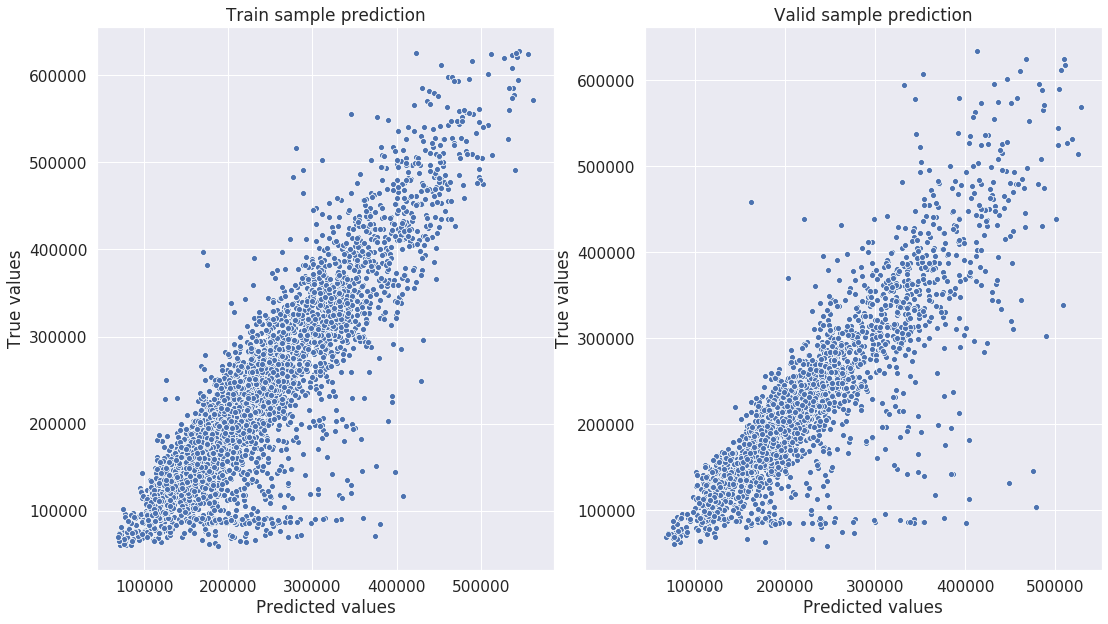

In [679]:
### Initialize CatBoostRegressor
model_cat = CatBoostRegressor(learning_rate=0.06,
                            depth=6,
                            l2_leaf_reg=1,
                            iterations=200,
                            loss_function='RMSE',
                            eval_metric='R2',
                            random_seed=21,
                            silent=True)
# Fit model
model_cat.fit(X_train, y_train)

y_train_preds = model_cat.predict(X_train)
y_valid_preds = model_cat.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [680]:
cv_score = cross_val_score(model_cat, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.75096192, 0.71634707, 0.71129056, 0.74257402, 0.74917314])

In [681]:
cv_score.mean()

0.7340693429303513

In [662]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_cat.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,36.865957
17,MedByHealth,11.407674
15,DistrictSize,6.667592
16,IsDistrictLarge,4.593070
6,HouseYear,4.470827
11,Social_3,3.971802
3,KitchenSquare,3.968029
0,Rooms,3.882186
7,Ecology_1,3.081660
5,HouseFloor,3.067501


### Прогнозирование на тестовом датасете 

In [663]:
test_df.shape

(5000, 25)

In [664]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Helthcare_2,Social_1,...,DistrictSize,IsDistrictLarge,MedByHealth,MedByESD,MedByEHM,HouseFloor_outlier,HouseYear_outlier,MedByEcSocD,Ecology_2_code,Ecology_3_code
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,24,...,76.0,0,234259.487117,44.0,44.0,0,0,44.0,1.0,1.0
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,0,2,...,164.0,1,173615.589116,27.0,27.0,0,0,27.0,1.0,1.0
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,0,9,...,580.0,1,173615.589116,27.0,27.0,0,0,27.0,1.0,1.0
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,0,2,...,372.0,1,173615.589116,23.0,23.0,0,0,23.0,1.0,1.0
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,0,35,...,65.0,0,212701.860687,19.0,19.0,0,0,19.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,1,31,...,56.0,0,234077.960019,29.0,29.0,1,0,29.0,1.0,1.0
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,0,15,...,26.0,0,296599.512131,38.0,38.0,0,0,38.0,1.0,1.0
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,2,28,...,54.0,0,202938.765564,11.0,11.0,0,0,11.0,1.0,1.0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,0,33,...,40.0,0,173615.589116,10.0,10.0,0,0,10.0,1.0,1.0


In [665]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [666]:
predictions = model_cat.predict(test_df)
predictions

array([164945.70937953, 115343.1915965 , 163158.98889043, ...,
       143349.23043953, 189433.5004894 , 237323.20459473])

In [667]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164945.709380
1,5925,115343.191596
2,960,163158.988890
3,3848,118330.065313
4,746,202817.003440


In [668]:
submit.to_csv('./submission.csv', index=False)